# DeepDreaming with TensorFlow

>[Loading and displaying the model graph](#loading)

>[Naive feature visualization](#naive)

>[Multiscale image generation](#multiscale)

>[Laplacian Pyramid Gradient Normalization](#laplacian)

>[Playing with feature visualzations](#playing)

>[DeepDream](#deepdream)



This notebook demonstrates a number of Convolutional Neural Network image generation techniques implemented with TensorFlow for fun and science:

- visualize individual feature channels and their combinations to explore the space of patterns learned by the neural network (see [GoogLeNet](http://storage.googleapis.com/deepdream/visualz/tensorflow_inception/index.html) and [VGG16](http://storage.googleapis.com/deepdream/visualz/vgg16/index.html) galleries)
- embed TensorBoard graph visualizations into Jupyter notebooks
- produce high-resolution images with tiled computation ([example](http://storage.googleapis.com/deepdream/pilatus_flowers.jpg))
- use Laplacian Pyramid Gradient Normalization to produce smooth and colorful visuals at low cost
- generate DeepDream-like images with TensorFlow (DogSlugs included)


The network under examination is the [GoogLeNet architecture](http://arxiv.org/abs/1409.4842), trained to classify images into one of 1000 categories of the [ImageNet](http://image-net.org/) dataset. It consists of a set of layers that apply a sequence of transformations to the input image. The parameters of these transformations were determined during the training process by a variant of gradient descent algorithm. The internal image representations may seem obscure, but it is possible to visualize and interpret them. In this notebook we are going to present a few tricks that allow to make these visualizations both efficient to generate and even beautiful. Impatient readers can start with exploring the full galleries of images generated by the method described here for [GoogLeNet](http://storage.googleapis.com/deepdream/visualz/tensorflow_inception/index.html) and [VGG16](http://storage.googleapis.com/deepdream/visualz/vgg16/index.html) architectures.

In [69]:
# boilerplate code
from __future__ import print_function
import os
from io import BytesIO
import numpy as np
from functools import partial
import PIL.Image
from IPython.display import clear_output, Image, display, HTML

import tensorflow as tf

<a id='loading'></a>
## Loading and displaying the model graph

The pretrained network can be downloaded [here](https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip). Unpack the `tensorflow_inception_graph.pb` file from the archive and set its path to `model_fn` variable. Alternatively you can uncomment and run the following cell to download the network:

In [70]:
#!wget https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip && unzip inception5h.zip

In [71]:
# model_fn = 'tensorflow_inception_graph.pb'
#CHANGED THIS TO MY GRAPH
model_fn = 'retrained_graph.pb'

# creating TensorFlow session and loading the model
graph = tf.Graph()
sess = tf.InteractiveSession(graph=graph)
with tf.gfile.FastGFile(model_fn, 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
t_input = tf.placeholder(np.float32, name='input') # define the input tensor
imagenet_mean = 117.0
t_preprocessed = tf.expand_dims(t_input-imagenet_mean, 0)
#HAD TO CHANGE THIS
tf.import_graph_def(graph_def, name='')
#tf.import_graph_def(graph_def, {'input':t_preprocessed})

To take a glimpse into the kinds of patterns that the network learned to recognize, we will try to generate images that maximize the sum of activations of particular channel of a particular convolutional layer of the neural network. The network we explore contains many convolutional layers, each of which outputs tens to hundreds of feature channels, so we have plenty of patterns to explore.

In [72]:
#HAD TO CHANGE THIS - NOT LAYERS WITH 'IMPORT/' IN NAME
# layers = [op.name for op in graph.get_operations() if op.type=='Conv2D' and 'import/' in op.name]
layers = [op.name for op in graph.get_operations() if op.type=='Conv2D']
feature_nums = [int(graph.get_tensor_by_name(name+':0').get_shape()[-1]) for name in layers]

#ADDED THIS LINE TO SEE ALL LAYERS PRINTED
print([op.name for op in graph.get_operations()])
print('Number of layers', len(layers))
print('Total number of feature channels:', sum(feature_nums))


# Helper functions for TF Graph visualization

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = bytes("<stripped %d bytes>"%size, 'utf-8')
    return strip_def
  
def rename_nodes(graph_def, rename_func):
    res_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = res_def.node.add() 
        n.MergeFrom(n0)
        n.name = rename_func(n.name)
        for i, s in enumerate(n.input):
            n.input[i] = rename_func(s) if s[0]!='^' else '^'+rename_func(s[1:])
    return res_def
  
def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))
  
    iframe = """
        <iframe seamless style="width:800px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

# Visualizing the network graph. Be sure expand the "mixed" nodes to see their 
# internal structure. We are going to visualize "Conv2D" nodes.
tmp_def = rename_nodes(graph_def, lambda s:"/".join(s.split('_',1)))
show_graph(tmp_def)

['input', 'sub/y', 'sub', 'ExpandDims/dim', 'ExpandDims', 'DecodeJpeg/contents', 'DecodeJpeg', 'Cast', 'ExpandDims/dim_1', 'ExpandDims_1', 'ResizeBilinear/size', 'ResizeBilinear', 'Sub/y', 'Sub', 'Mul/y', 'Mul', 'conv/conv2d_params', 'conv/Conv2D', 'conv/batchnorm/beta', 'conv/batchnorm/gamma', 'conv/batchnorm/moving_mean', 'conv/batchnorm/moving_variance', 'conv/batchnorm', 'conv/CheckNumerics', 'conv/control_dependency', 'conv', 'conv_1/conv2d_params', 'conv_1/Conv2D', 'conv_1/batchnorm/beta', 'conv_1/batchnorm/gamma', 'conv_1/batchnorm/moving_mean', 'conv_1/batchnorm/moving_variance', 'conv_1/batchnorm', 'conv_1/CheckNumerics', 'conv_1/control_dependency', 'conv_1', 'conv_2/conv2d_params', 'conv_2/Conv2D', 'conv_2/batchnorm/beta', 'conv_2/batchnorm/gamma', 'conv_2/batchnorm/moving_mean', 'conv_2/batchnorm/moving_variance', 'conv_2/batchnorm', 'conv_2/CheckNumerics', 'conv_2/control_dependency', 'conv_2', 'pool/CheckNumerics', 'pool/control_dependency', 'pool', 'conv_3/conv2d_params'

<a id='naive'></a>
## Naive feature visualization

Let's start with a naive way of visualizing these. Image-space gradient ascent!

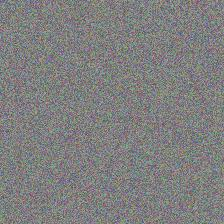

In [73]:
# Picking some internal layer. Note that we use outputs before applying the ReLU nonlinearity
# to have non-zero gradients for features with negative initial activations.

#SWITCHED LAYER TO THE FINAL LAYER OF MY GRAPH
#layer = 'mixed4d_3x3_bottleneck_pre_relu'
layer = 'final_result:0'
channel = 0 # picking some feature channel to visualize

# start with a gray image with a little noise
img_noise = np.random.uniform(size=(224,224,3)) + 100.0


def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 1)*255)
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))
    
def visstd(a, s=0.1):
    '''Normalize the image range for visualization'''
    return (a-a.mean())/max(a.std(), 1e-4)*s + 0.5

def T(layer):
    '''Helper for getting layer output tensor'''
#     return graph.get_tensor_by_name("import/%s:0"%layer)
#TRYING TO RESIZE THE TENSOR TO GET IT TO WORK, BUT JUST GUESSING HONESTLY
#     print(tf.shape(tf.reshape(graph.get_tensor_by_name(layer), [-1,-1,-1,-1], name=None)))
#     print(graph.get_tensor_by_name(layer))
    return tf.reshape(graph.get_tensor_by_name(layer), [2,1,1,1], name=None)
#     return graph.get_tensor_by_name(layer)

def render_naive(t_obj, img0=img_noise, iter_n=20, step=1.0):
    t_score = tf.reduce_mean(t_obj) # defining the optimization objective
    t_grad = tf.gradients(t_score, t_input)[0] # behold the power of automatic differentiation!
    
    img = img0.copy()
    for i in range(iter_n):
        #g, score = sess.run([t_grad, t_score], {t_input:img})
        g, score = sess.run(t_obj, {t_input:img})
        # normalizing the gradient, so the same step size should work 
        g /= g.std()+1e-8         # for different layers and networks
        img += g*step
        print(score, end = ' ')
    clear_output()
    showarray(visstd(img))

render_naive(T(layer)[:][:,:,:,channel])

<a id="multiscale"></a>
## Multiscale image generation

Looks like the network wants to show us something interesting! Let's help it. We are going to apply gradient ascent on multiple scales. Details formed on smaller scale will be upscaled and augmented with additional details on the next scale.

With multiscale image generation it may be tempting to set the number of octaves to some high value to produce wallpaper-sized images. Storing network activations and backprop values will quickly run out of GPU memory in this case. There is a simple trick to avoid this: split the image into smaller tiles and compute each tile gradient independently. Applying random shifts to the image before every iteration helps avoid tile seams and improves the overall image quality.

In [74]:
img_noise = np.random.uniform(size=(224,224,3)) + 100.0

def tffunc(*argtypes):
    '''Helper that transforms TF-graph generating function into a regular one.
    See "resize" function below.
    '''
    placeholders = list(map(tf.placeholder, argtypes))
    def wrap(f):
        out = f(*placeholders)
        def wrapper(*args, **kw):
            return out.eval(dict(zip(placeholders, args)), session=kw.get('session'))
        return wrapper
    return wrap

# Helper function that uses TF to resize an image
def resize(img, size):
    img = tf.expand_dims(img, 0)
    return tf.image.resize_bilinear(img, size)[0,:,:,:]
resize = tffunc(np.float32, np.int32)(resize)


def calc_grad_tiled(img, t_grad, tile_size=512):
    '''Compute the value of tensor t_grad over the image in a tiled way.
    Random shifts are applied to the image to blur tile boundaries over 
    multiple iterations.'''
    sz = tile_size
    h, w = img.shape[:2]
    sx, sy = np.random.randint(sz, size=2)
    img_shift = np.roll(np.roll(img, sx, 1), sy, 0)
    grad = np.zeros_like(img)
    for y in range(0, max(h-sz//2, sz),sz):
        for x in range(0, max(w-sz//2, sz),sz):
            sub = img_shift[y:y+sz,x:x+sz]
            g = sess.run(t_grad, {t_input:sub})
            grad[y:y+sz,x:x+sz] = g
    return np.roll(np.roll(grad, -sx, 1), -sy, 0)

In [75]:
def render_multiscale(t_obj, img0=img_noise, iter_n=10, step=1.0, octave_n=3, octave_scale=1.4):
    t_score = tf.reduce_mean(t_obj) # defining the optimization objective
    t_grad = tf.gradients(t_score, t_input)[0] # behold the power of automatic differentiation!
    
    img = img0.copy()
    for octave in range(octave_n):
        if octave>0:
            hw = np.float32(img.shape[:2])*octave_scale
            img = resize(img, np.int32(hw))
        for i in range(iter_n):
            g = calc_grad_tiled(img, t_grad)
            # normalizing the gradient, so the same step size should work 
            g /= g.std()+1e-8         # for different layers and networks
            img += g*step
            print('.', end = ' ')
        clear_output()
        showarray(visstd(img))

render_multiscale(T(layer)[:,:,:,channel])

TypeError: Fetch argument None has invalid type <class 'NoneType'>

<a id="laplacian"></a>
## Laplacian Pyramid Gradient Normalization

This looks better, but the resulting images mostly contain high frequencies. Can we improve it? One way is to add a smoothness prior into the optimization objective. This will effectively blur the image a little every iteration, suppressing the higher frequencies, so that the lower frequencies can catch up. This will require more iterations to produce a nice image. Why don't we just boost lower frequencies of the gradient instead? One way to achieve this is through the [Laplacian pyramid](https://en.wikipedia.org/wiki/Pyramid_%28image_processing%29#Laplacian_pyramid) decomposition. We call the resulting technique _Laplacian Pyramid Gradient Normalization_.

In [ ]:
k = np.float32([1,4,6,4,1])
k = np.outer(k, k)
k5x5 = k[:,:,None,None]/k.sum()*np.eye(3, dtype=np.float32)

def lap_split(img):
    '''Split the image into lo and hi frequency components'''
    with tf.name_scope('split'):
        lo = tf.nn.conv2d(img, k5x5, [1,2,2,1], 'SAME')
        lo2 = tf.nn.conv2d_transpose(lo, k5x5*4, tf.shape(img), [1,2,2,1])
        hi = img-lo2
    return lo, hi

def lap_split_n(img, n):
    '''Build Laplacian pyramid with n splits'''
    levels = []
    for i in range(n):
        img, hi = lap_split(img)
        levels.append(hi)
    levels.append(img)
    return levels[::-1]

def lap_merge(levels):
    '''Merge Laplacian pyramid'''
    img = levels[0]
    for hi in levels[1:]:
        with tf.name_scope('merge'):
            img = tf.nn.conv2d_transpose(img, k5x5*4, tf.shape(hi), [1,2,2,1]) + hi
    return img

def normalize_std(img, eps=1e-10):
    '''Normalize image by making its standard deviation = 1.0'''
    with tf.name_scope('normalize'):
        std = tf.sqrt(tf.reduce_mean(tf.square(img)))
        return img/tf.maximum(std, eps)

def lap_normalize(img, scale_n=4):
    '''Perform the Laplacian pyramid normalization.'''
    img = tf.expand_dims(img,0)
    tlevels = lap_split_n(img, scale_n)
    tlevels = list(map(normalize_std, tlevels))
    out = lap_merge(tlevels)
    return out[0,:,:,:]

# Showing the lap_normalize graph with TensorBoard
lap_graph = tf.Graph()
with lap_graph.as_default():
    lap_in = tf.placeholder(np.float32, name='lap_in')
    lap_out = lap_normalize(lap_in)
show_graph(lap_graph)

In [ ]:
def render_lapnorm(t_obj, img0=img_noise, visfunc=visstd,
                   iter_n=10, step=1.0, octave_n=3, octave_scale=1.4, lap_n=4):
    t_score = tf.reduce_mean(t_obj) # defining the optimization objective
    t_grad = tf.gradients(t_score, t_input)[0] # behold the power of automatic differentiation!
    # build the laplacian normalization graph
    lap_norm_func = tffunc(np.float32)(partial(lap_normalize, scale_n=lap_n))

    img = img0.copy()
    for octave in range(octave_n):
        if octave>0:
            hw = np.float32(img.shape[:2])*octave_scale
            img = resize(img, np.int32(hw))
        for i in range(iter_n):
            g = calc_grad_tiled(img, t_grad)
            g = lap_norm_func(g)
            img += g*step
            print('.', end = ' ')
        clear_output()
        showarray(visfunc(img))

render_lapnorm(T(layer)[:,:,:,channel])

<a id="playing"></a>
## Playing with feature visualizations

We got a nice smooth image using only 10 iterations per octave. In case of running on GPU this takes just a few seconds. Let's try to visualize another channel from the same layer. The network can generate wide diversity of patterns.

In [ ]:
render_lapnorm(T(layer)[:,:,:,65])

Lower layers produce features of lower complexity.

In [ ]:
render_lapnorm(T('mixed3b_1x1_pre_relu')[:,:,:,101])

There are many interesting things one may try. For example, optimizing a linear combination of features often gives a "mixture" pattern.

In [ ]:
render_lapnorm(T(layer)[:,:,:,65]+T(layer)[:,:,:,139], octave_n=4)

<a id="deepdream"></a>
## DeepDream

Now let's reproduce the [DeepDream algorithm](https://github.com/google/deepdream/blob/master/dream.ipynb) with TensorFlow. 


In [ ]:
def render_deepdream(t_obj, img0=img_noise,
                     iter_n=10, step=1.5, octave_n=4, octave_scale=1.4):
    t_score = tf.reduce_mean(t_obj) # defining the optimization objective
    t_grad = tf.gradients(t_score, t_input)[0] # behold the power of automatic differentiation!

    # split the image into a number of octaves
    img = img0
    octaves = []
    for i in range(octave_n-1):
        hw = img.shape[:2]
        lo = resize(img, np.int32(np.float32(hw)/octave_scale))
        hi = img-resize(lo, hw)
        img = lo
        octaves.append(hi)
    
    # generate details octave by octave
    for octave in range(octave_n):
        if octave>0:
            hi = octaves[-octave]
            img = resize(img, hi.shape[:2])+hi
        for i in range(iter_n):
            g = calc_grad_tiled(img, t_grad)
            img += g*(step / (np.abs(g).mean()+1e-7))
            print('.',end = ' ')
        clear_output()
        showarray(img/255.0)

Let's load some image and populate it with DogSlugs (in case you've missed them).

In [ ]:
img0 = PIL.Image.open('eschertest.jpg')
img0 = np.float32(img0)
showarray(img0/255.0)

In [ ]:
render_deepdream(tf.square(T('mixed4c')), img0)

Note that results can differ from the [Caffe](https://github.com/BVLC/caffe)'s implementation, as we are using an independently trained network. Still, the network seems to like dogs and animal-like features due to the nature of the ImageNet dataset.

Using an arbitrary optimization objective still works:

In [ ]:
render_deepdream(T(layer)[:,:,:,139], img0)

Don't hesitate to use higher resolution inputs (also increase the number of octaves)! Here is an [example](http://storage.googleapis.com/deepdream/pilatus_flowers.jpg) of running the flower dream over the bigger image.

We hope that the visualization tricks described here may be helpful for analyzing representations learned by neural networks or find their use in various artistic applications.